This is the extended version of obesity risk prediction model in this we will try to cluster the data and try to analyse the clusters to recommend some tips for good health on the basis of characterstics of each cluster

## **All the preprocessing steps done in main classification model notebook**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# for importing data directly form google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# unzip the data folder
!unzip '/content/drive/MyDrive/playground-series-s4e2.zip'

Archive:  /content/drive/MyDrive/playground-series-s4e2.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [4]:
# reading training and testing dataset
df= pd.read_csv("/content/train.csv")

In [ ]:
#printing frist 10 rows of data
df.head(5)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [ ]:
## adding BMI column as it will give a relation between height and weight and can relate more to obesity level.
## formula for calculating BMI is :  weight (kg) / [height (m)]2
df['BMI'] = df['Weight']/(df['Height'])**2

In [ ]:
df.rename(columns = {'NObeyesdad':'obesity_level'}, inplace = True)

In [ ]:
df['obesity_level'].value_counts()

obesity_level
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

In [ ]:
df.columns

Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'obesity_level',
       'BMI'],
      dtype='object')

In [ ]:
oe = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value= -1,categories = [['Always','Frequently','Sometimes','No'],['Frequently','Sometimes','No']])
train_arr = oe.fit_transform(df[['CAEC','CALC']])

In [ ]:
ord = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value= -1, categories = [['Insufficient_Weight','Normal_Weight','Overweight_Level_I','Overweight_Level_II','Obesity_Type_I','Obesity_Type_II','Obesity_Type_III']])
df['obesity_level'] = ord.fit_transform(df[['obesity_level']])

In [ ]:
df[['CAEC','CALC']] = train_arr

In [ ]:
cat_cols_enc= ['Gender','family_history_with_overweight','FAVC','SMOKE','SCC','MTRANS']

In [ ]:
ohe = OneHotEncoder(drop = 'first',sparse_output=False)
train_enc = pd.DataFrame(ohe.fit_transform(df[cat_cols_enc]))

In [ ]:
train_enc.rename(columns = {0:'Gender',1:'family_history_with_overweight',2:'FAVC',3:'SMOKE',4:'SCC',5:'MTRANS_Bike',6:'MTRANS_Motorbike',
                            7:'MTRANS_Public_Transportation',8:'MTRANS_Walking'},inplace = True)

In [ ]:
train_enc.index = df.index

In [ ]:
df.drop(columns = cat_cols_enc, inplace = True)

In [ ]:
df = pd.concat([df,train_enc],axis= 1)

In [ ]:
df

,id,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,...,BMI,Gender,family_history_with_overweight,FAVC,SMOKE,SCC,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,24.443011,1.699998,81.669950,2.000000,2.983297,2.0,2.763573,0.000000,0.976473,...,28.259565,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,18.000000,1.560000,57.000000,2.000000,3.000000,1.0,2.000000,1.000000,1.000000,...,23.422091,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,18.000000,1.711460,50.165754,1.880534,1.411685,2.0,1.910378,0.866045,1.673584,...,17.126706,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,20.952737,1.710730,131.274851,3.000000,3.000000,2.0,1.674061,1.467863,0.780199,...,44.855798,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,31.641081,1.914186,93.798055,2.679664,1.971472,2.0,1.979848,1.967973,0.931721,...,25.599151,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.0,2.151809,1.330519,0.196680,...,36.587084,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
20754,20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.0,1.000000,2.000000,1.000000,...,17.099278,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
20755,20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.0,2.000000,1.158040,1.198439,...,31.889841,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
20756,20756,33.852953,1.700000,83.520113,2.671238,1.971472,2.0,2.144838,0.000000,0.973834,...,28.899693,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.columns

Index(['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF',
       'TUE', 'CALC', 'obesity_level', 'BMI', 'Gender',
       'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS_Bike',
       'MTRANS_Motorbike', 'MTRANS_Public_Transportation', 'MTRANS_Walking'],
      dtype='object')

In [ ]:
df.drop(columns = 'id', inplace = True)

## **K-Means clustering**

In [ ]:
def kmeans_plot(X, start_k, end_k):
  from sklearn.cluster import KMeans
  from sklearn.metrics import silhouette_score
  wcss = []
  ss = []
  for k in range(start_k,end_k +1):
    km = KMeans(n_clusters = k, n_init = "auto", random_state = 42)
    km.fit(X)
    wcss.append(km.inertia_)
    ss_score = silhouette_score(X, km.labels_, random_state = 42)
    ss.append(ss_score)
  # silhoutte plot
  fig, axs = plt.subplots(2,1)
  axs[0].plot(range(start_k,end_k +1), wcss, marker = "*")
  axs[0].set_title("Elbow_plot")
  axs[1].plot(range(start_k,end_k +1), ss, marker = "*")
  axs[1].set_title("Silhoutte Plot")
  plt.tight_layout()
  plt.show()

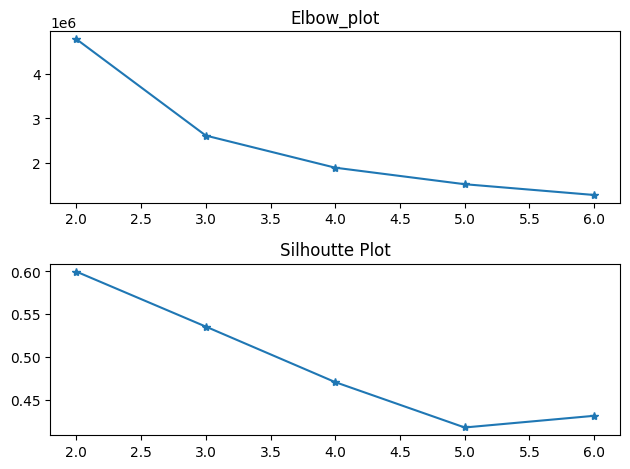

In [ ]:
# full data
kmeans_plot(df,2,6)

-- we are not getting a proper silhoutte plot, will try some more experimnents although we are getting silhoutte score more 0.5 at 3 clusters but that will be very less no. of clusters.

In [ ]:
df_1 = df.drop(columns = 'obesity_level')

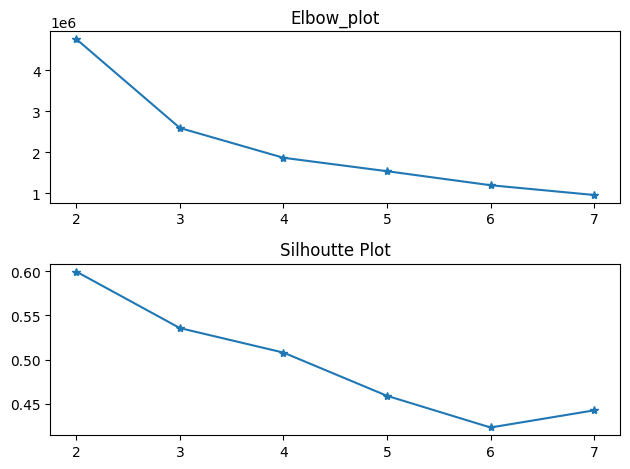

In [ ]:
# without output column
kmeans_plot(df_1,2,7)

-- got a better score at 4 clusters but will continue to experiment in order to improve it

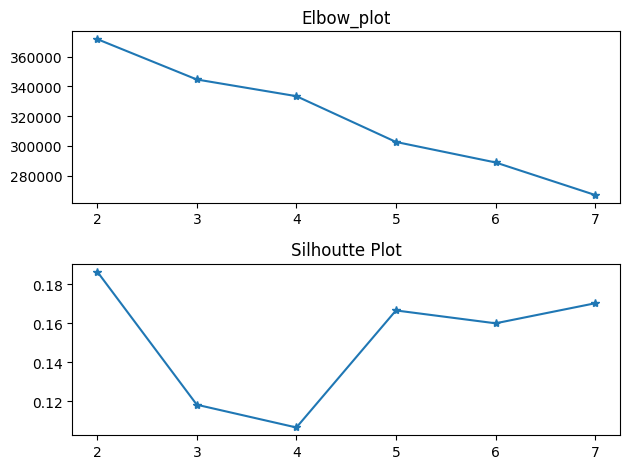

In [ ]:

std_scaler = StandardScaler()
# with scaling of full data
kmeans_plot(std_scaler.fit_transform(df),2,7)

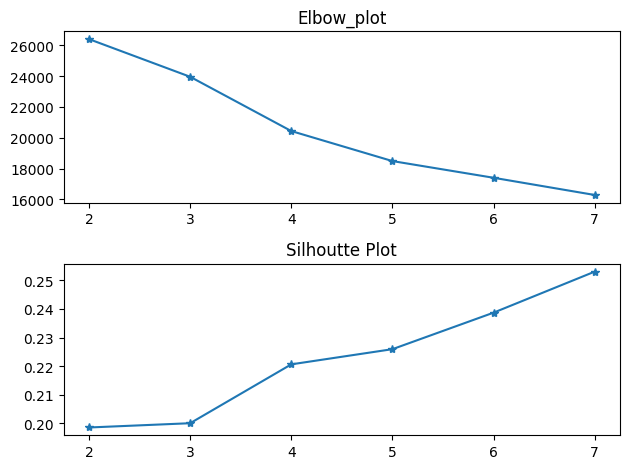

In [ ]:
min_max_scaler = MinMaxScaler()
# with min_max scaling of full data
kmeans_plot(min_max_scaler.fit_transform(df),2,7)

-- doing scaling on full data is decreasing the silhoutte score, scaling is not performing well.

<Axes: >

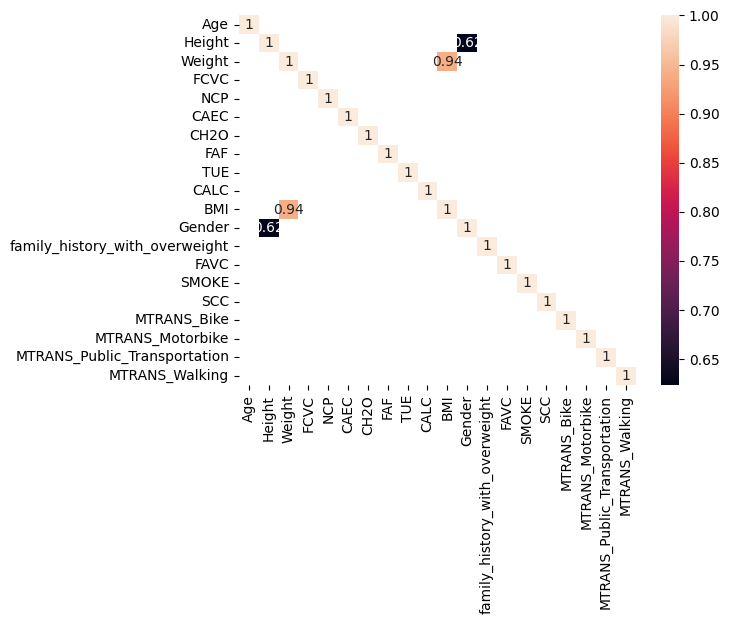

In [ ]:
# finding columns with high correlation
sns.heatmap(df_1.corr()[df_1.corr() > 0.60], annot = True)

In [ ]:
# removing columns with high correaltion and then again chaecking silhoutte score
df2 = df_1.drop(columns = ['Height','BMI'])

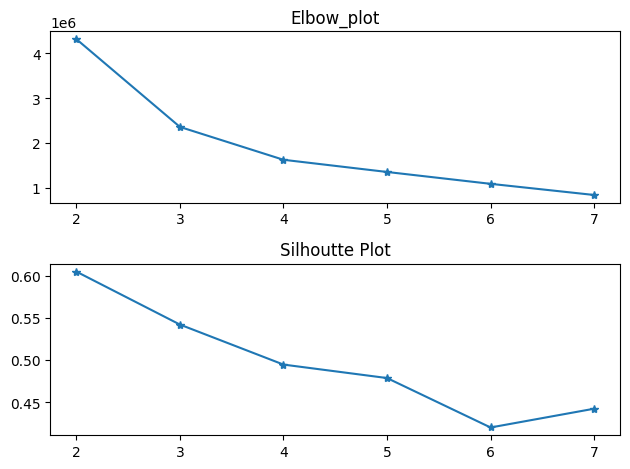

In [ ]:
kmeans_plot(df2,2,7)

-- this is also not improving siloutte score

In [ ]:
# trying to make clusters with pca data
pca_df = PCA(n_components=4)
principalComponents_df = pca_df.fit_transform(df2)

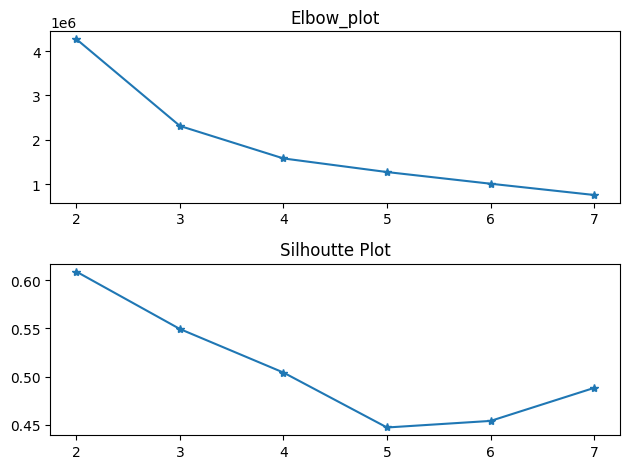

In [ ]:
kmeans_plot(principalComponents_df,2,7)

-- still not improving score so we will not perform pca.

In [ ]:
# imporatnt columns on which classification model is trained
imp_col = ['Age', 'Height', 'Weight', 'FCVC','CAEC', 'CH2O','TUE','BMI','Gender','family_history_with_overweight','NCP','FAF']

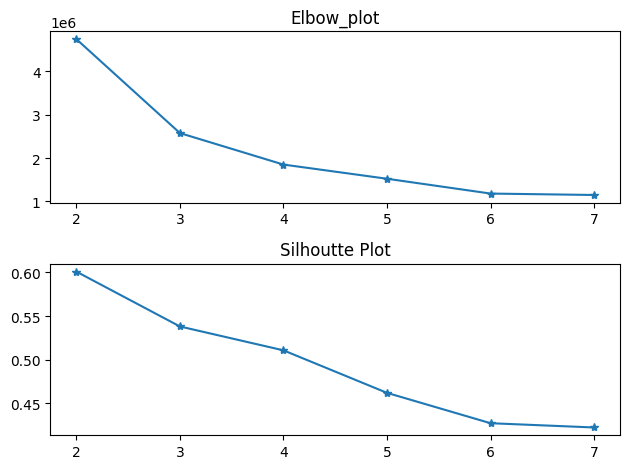

In [ ]:
kmeans_plot(df_1[imp_col], 2,7)

In [ ]:
df4 = df_1[imp_col]

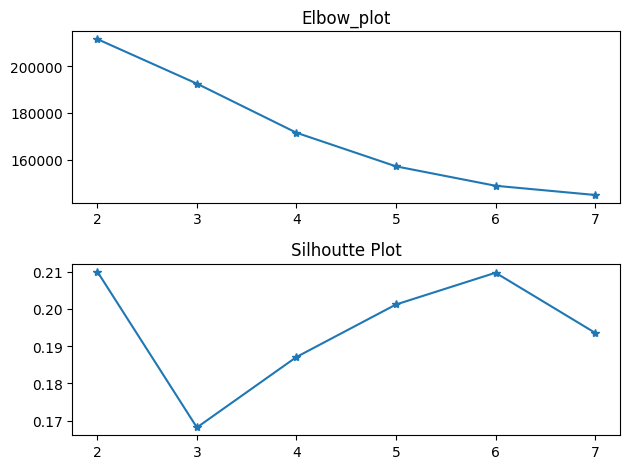

In [ ]:
kmeans_plot(std_scaler.fit_transform(df4),2,7)

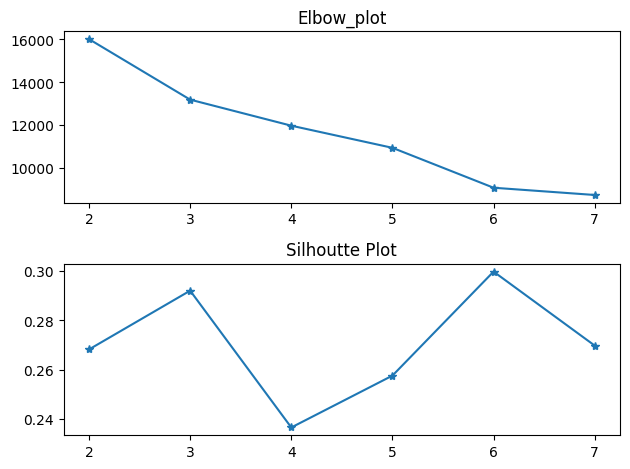

In [ ]:
kmeans_plot(min_max_scaler.fit_transform(df4),2,7)

In [ ]:
# calculate vif
import statsmodels.stats.outliers_influence as oi


def calculate_vif(X):
    vif = pd.DataFrame()
    vif['Variables'] = df4.columns
    vif['VIF'] = [oi.variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif



In [ ]:
vif = calculate_vif(df4)
vif.sort_values(by = ["VIF"], ascending = False)

,Variables,VIF
7,BMI,210.042451
2,Weight,174.857986
1,Height,88.044467
3,FCVC,27.985600
0,Age,24.510780
10,NCP,17.448574
4,CAEC,14.270768
5,CH2O,14.023794
9,family_history_with_overweight,7.981507
8,Gender,3.671484


After a lot of expermients it is giving almost same results so for K-means clustering we will finalise this result as it is performing same with less columns we will keep that.<br>
We can finalise for clusters as 2 or 3 clusters will be very less for such a diverse data and at 4 clusters it is giving more 0.5 silhoutte score which is reducing for 5 and more clusters and also elbow plot is good at 4 clusters.<br>
Although we will try few more experimnets with DBScan and Hierarchial clustering.

## **Heirarchial Clustering**

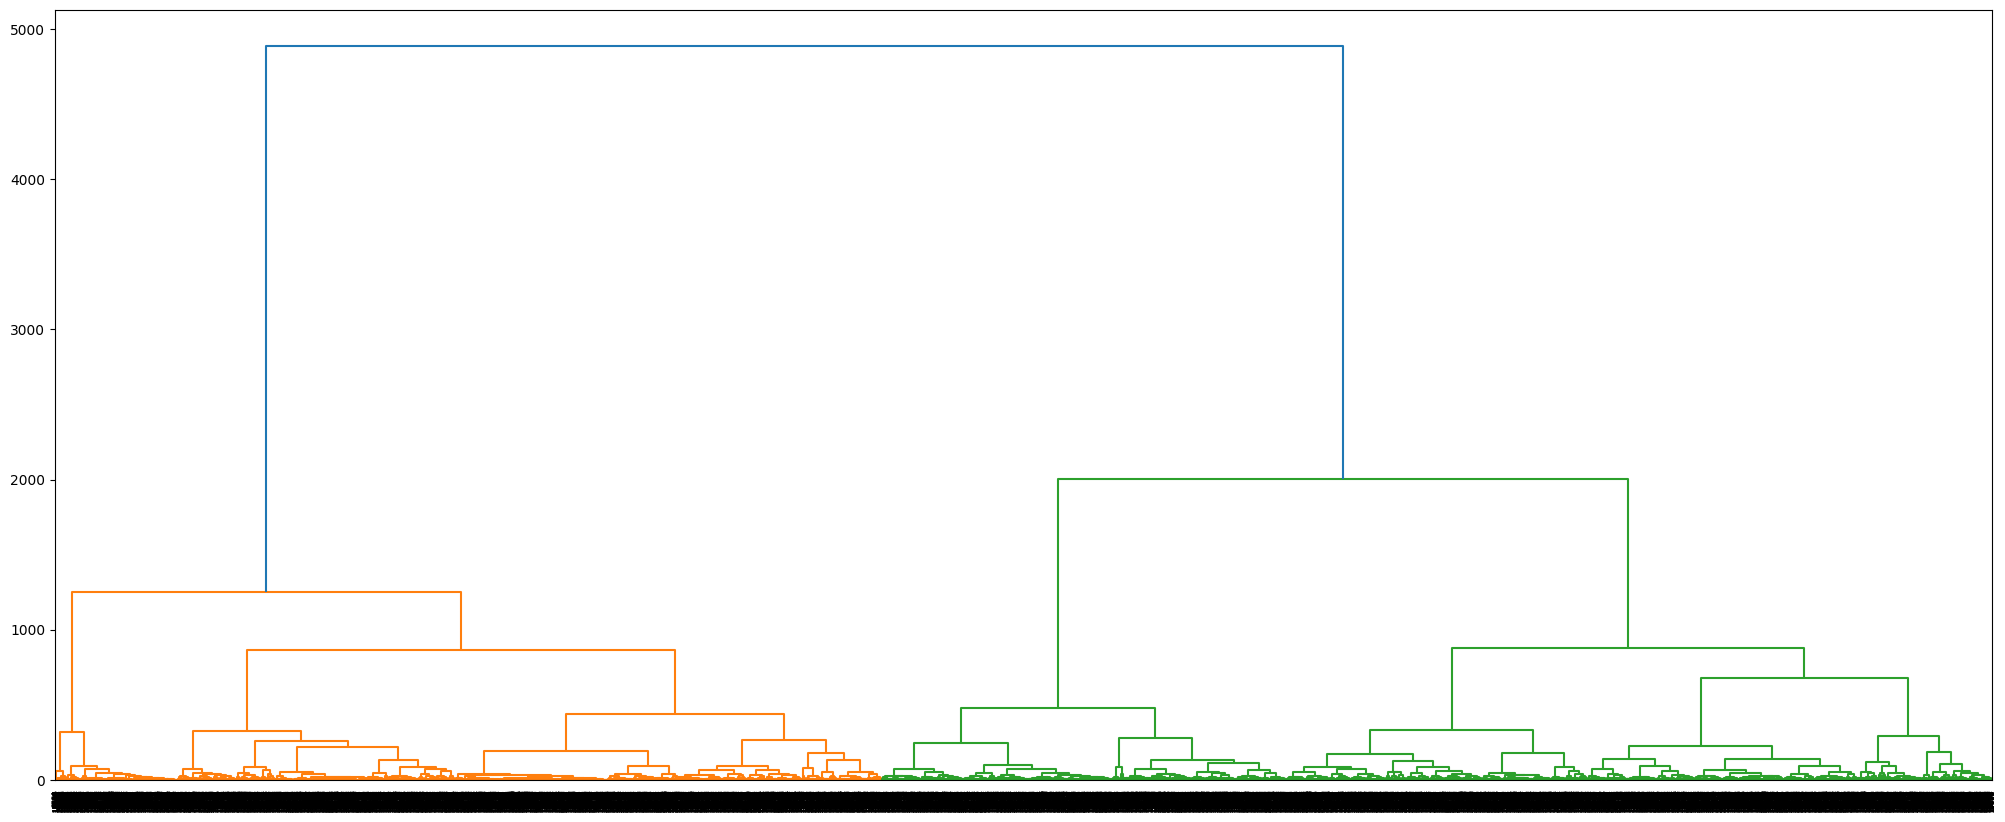

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(df, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

-- it is only making 2 clusters.

In [ ]:
def hc_plot(X, start_k, end_k):
  from sklearn.cluster import AgglomerativeClustering
  from sklearn.metrics import silhouette_score
  # wcss = []
  ss = []
  for k in range(start_k,end_k +1):
    hc = AgglomerativeClustering(n_clusters = k)
    hc.fit(X)
    # wcss.append(hc.inertia_)
    ss_score = silhouette_score(X, hc.labels_, random_state = 42)
    ss.append(ss_score)
  # silhoutte plot
  fig = plt.plot(range(start_k,end_k +1), ss, marker = "*")
  plt.title("Silhoutte Plot")
  plt.tight_layout()
  plt.show()

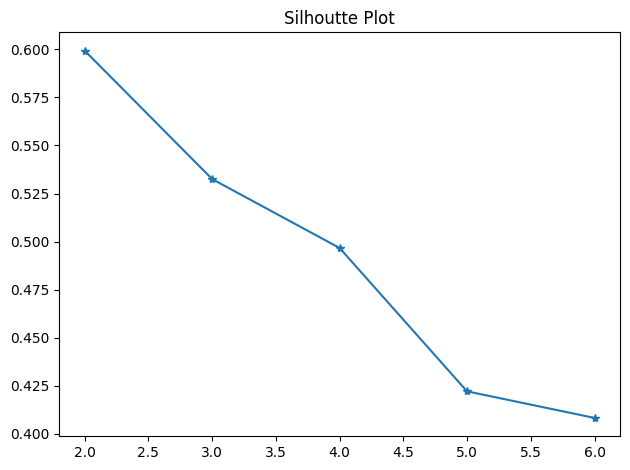

In [ ]:
hc_plot(df,2,6)

## **DBScan**

In [ ]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=4, min_samples = 200)
db.fit(df2)
labels = db.labels_

In [ ]:
df2['db'] = db.labels_

In [ ]:
df2['db'].value_counts(1)

db
 0    0.900906
 1    0.054822
-1    0.044272
Name: proportion, dtype: float64

this is not performing well as it is making one major clsuter with 90% of data we will try to tune it iteratively.

In [ ]:
range_eps = [1,2,3,4,5,6,7]
for i in range_eps:
  print('eps value is' + str(i))
  db = DBSCAN(eps = i, min_samples = 5).fit(df2)
  labels = db.labels_
  print(set(labels))
  silhoutte_avg = silhouette_score(df,labels)
  print('eps value is' + str(i), labels,
        "The average silhoutte score is:",silhoutte_avg)


eps value is1
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, -1}
eps value is1 [-1 -1 -1 ... -1 -1  6] The average silhoutte score is: -0.3841582061835915
eps value is2
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, -1}
eps value is2 [0 0 0 ... 0 0 0] The average silhoutte score is: -0.631098942368541
eps va

In [ ]:
range_eps = [1,2,3,4,5,6,7]
for i in range_eps:
  print('eps value is' + str(i))
  db = DBSCAN(eps = i, min_samples = 25).fit(df2)
  labels = db.labels_
  print(set(labels))
  silhoutte_avg = silhouette_score(df,labels)
  print('eps value is' + str(i), labels,
        "The average silhoutte score is:",silhoutte_avg)



eps value is1
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, -1}
eps value is1 [-1 -1 -1 ... -1 -1  4] The average silhoutte score is: -0.35576006351716283
eps value is2
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, -1}
eps value is2 [ 0  2  2 ...  3 14  3] The average silhoutte score is: -0.05037109626614386
eps value is3
{0, 1, 2, 3, 4, 5, -1}
eps value is3 [0 0 0 ... 0 0 0] The average silhoutte score is: -0.37723450505415385
eps value is4
{0, 1, 2, -1}
eps value is4 [0 0 0 ... 0 0 0] The average silhoutte score is: 0.09560550016751315
eps value is5
{0, 1, -1}
eps value is5 [0 0 0 ... 0 0 0] The average silhoutte score is: 0.17473261794287406
eps value is6
{0, -1}
eps value is6 [0 0 0 ... 0 0 0] The average silhoutte score is: 0.2195002448989939
eps value is7
{0, -1}
eps value is7 [0 0 0 ... 0 0 0] The average silhoutte score is: 0.29200773044856076


In [ ]:
range_eps = [1,2,3,4,5,6,7]
for i in range_eps:
  print('eps value is' + str(i))
  db = DBSCAN(eps = i, min_samples = 25).fit(principalComponents_df)
  labels = db.labels_
  print(set(labels))
  silhoutte_avg = silhouette_score(principalComponents_df,labels)
  print('eps value is' + str(i), labels,
        "The average silhoutte score is:",silhoutte_avg)

eps value is1
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, -1}
eps value is1 [-1 14  0 ... -1 22  4] The average silhoutte score is: -0.12187854071884027
eps value is2
{0, 1, 2, 3, 4, 5, -1}
eps value is2 [0 0 0 ... 0 0 0] The average silhoutte score is: -0.3350693547220845
eps value is3
{0, 1, 2, 3, 4, -1}
eps value is3 [0 0 0 ... 0 0 0] The average silhoutte score is: -0.3269256275254065
eps value is4
{0, 1, 2, -1}
eps value is4 [0 0 0 ... 0 0 0] The average silhoutte score is: 0.12304696862677987
eps value is5
{0, 1, -1}
eps value is5 [0 0 0 ... 0 0 0] The average silhoutte score is: 0.19949518957769583
eps value is6
{0, -1}
eps value is6 [0 0 0 ... 0 0 0] The average silhoutte score is: 0.30159016966669233
eps value is7
{0, -1}
eps value is7 [0 0 0 ... 0 0 0] The average silhoutte score is: 0.3093808484540386


In [ ]:
range_eps = [1,2,3,4,5,6,7]
for i in range_eps:
  print('eps value is' + str(i))
  db = DBSCAN(eps = i, min_samples = 25).fit(df4)
  labels = db.labels_
  print(set(labels))
  silhoutte_avg = silhouette_score(df4,labels)
  print('eps value is' + str(i), labels,
        "The average silhoutte score is:",silhoutte_avg)

eps value is1
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, -1}
eps value is1 [-1 -1 -1 ... -1 -1 -1] The average silhoutte score is: -0.3787645852233291
eps value is2
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, -1}
eps value is2 [ 4  1  1 ...  2 12  2] The average silhoutte score is: -0.05282359645197125
eps value is3
{0, 1, 2, 3, 4, 5, 6, -1}
eps value is3 [0 0 0 ... 0 0 0] The average silhoutte score is: -0.3179967534589624
eps value is4
{0, 1, 2, 3, -1}
eps value is4 [0 0 0 ... 0 0 0] The average silhoutte score is: -0.1277590080401192
eps value is5
{0, 1, 2, -1}
eps value is5 [0 0 0 ... 0 0 0] The average silhoutte score is: 0.09744765785051612
eps value is6
{0, -1}
eps value is6 [0 0 0 ... 0 0 0] The average silhoutte score is: 0.37051849474397774
eps value is7
{0, -1}
eps value is7 [0 0 0 ... 0 0 0] The average silhoutte score is: 0.2937568575331099


In [ ]:
range_minsamples = [20,25,40,50,75,100]
for i in range_minsamples:
  print('min_sample value is' + str(i))
  db = DBSCAN(eps = 5, min_samples = i ).fit(df4)
  labels = db.labels_
  print(set(labels))
  silhoutte_avg = silhouette_score(df4,labels)
  print('min_sample value is' + str(i), labels,
        "The average silhoutte score is:",silhoutte_avg,
        "total no of clusters are:"+ str(len(set(labels))))

min_sample value is20
{0, 1, -1}
min_sample value is20 [0 0 0 ... 0 0 0] The average silhoutte score is: 0.1738748536816056 total no of clusters are:3
min_sample value is25
{0, 1, 2, -1}
min_sample value is25 [0 0 0 ... 0 0 0] The average silhoutte score is: 0.09744765785051612 total no of clusters are:4
min_sample value is40
{0, 1, 2, -1}
min_sample value is40 [0 0 0 ... 0 0 0] The average silhoutte score is: 0.0974462683060061 total no of clusters are:4
min_sample value is50
{0, 1, 2, 3, -1}
min_sample value is50 [0 0 0 ... 0 0 0] The average silhoutte score is: -0.1205139559076692 total no of clusters are:5
min_sample value is75
{0, 1, 2, -1}
min_sample value is75 [0 0 0 ... 0 0 0] The average silhoutte score is: -0.12885826189422037 total no of clusters are:4
min_sample value is100
{0, 1, -1}
min_sample value is100 [0 0 0 ... 0 0 0] The average silhoutte score is: 0.09134221418632318 total no of clusters are:3


-- after a few experimnents we can see that dbscan is not giving good results and not able to make proper clusters we will now continue with k-means with important columns and do analysis.

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4, random_state = 42, n_init = "auto",max_iter = 1000)

km.fit(df4)

df4["k_value"] = km.labels_

<ipython-input-149-02ea890f7680>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["k_value"] = km.labels_


In [ ]:
df4

,Age,Height,Weight,FCVC,CAEC,CH2O,TUE,BMI,Gender,family_history_with_overweight,NCP,FAF,k_value
0,24.443011,1.699998,81.669950,2.000000,2.0,2.763573,0.976473,28.259565,1.0,1.0,2.983297,0.000000,0
1,18.000000,1.560000,57.000000,2.000000,1.0,2.000000,1.000000,23.422091,0.0,1.0,3.000000,1.000000,1
2,18.000000,1.711460,50.165754,1.880534,2.0,1.910378,1.673584,17.126706,0.0,1.0,1.411685,0.866045,1
3,20.952737,1.710730,131.274851,3.000000,2.0,1.674061,0.780199,44.855798,0.0,1.0,3.000000,1.467863,3
4,31.641081,1.914186,93.798055,2.679664,2.0,1.979848,0.931721,25.599151,1.0,1.0,1.971472,1.967973,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,2.0,2.151809,0.196680,36.587084,1.0,1.0,3.000000,1.330519,2
20754,18.000000,1.710000,50.000000,3.000000,1.0,1.000000,1.000000,17.099278,1.0,0.0,4.000000,2.000000,1
20755,20.101026,1.819557,105.580491,2.407817,2.0,2.000000,1.198439,31.889841,1.0,1.0,3.000000,1.158040,2
20756,33.852953,1.700000,83.520113,2.671238,2.0,2.144838,0.973834,28.899693,1.0,1.0,1.971472,0.000000,0


In [ ]:
df4['k_value'].value_counts(1)

k_value
2    0.334088
0    0.329078
1    0.261490
3    0.075344
Name: proportion, dtype: float64

## **Analysis of df with clusters**

<ipython-input-152-1d59e314fca4>:2: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(df4, x= 'FAF', y = 'Age', hue = 'k_value',  palette = sns.color_palette("flare"))


<Axes: xlabel='FAF', ylabel='Age'>

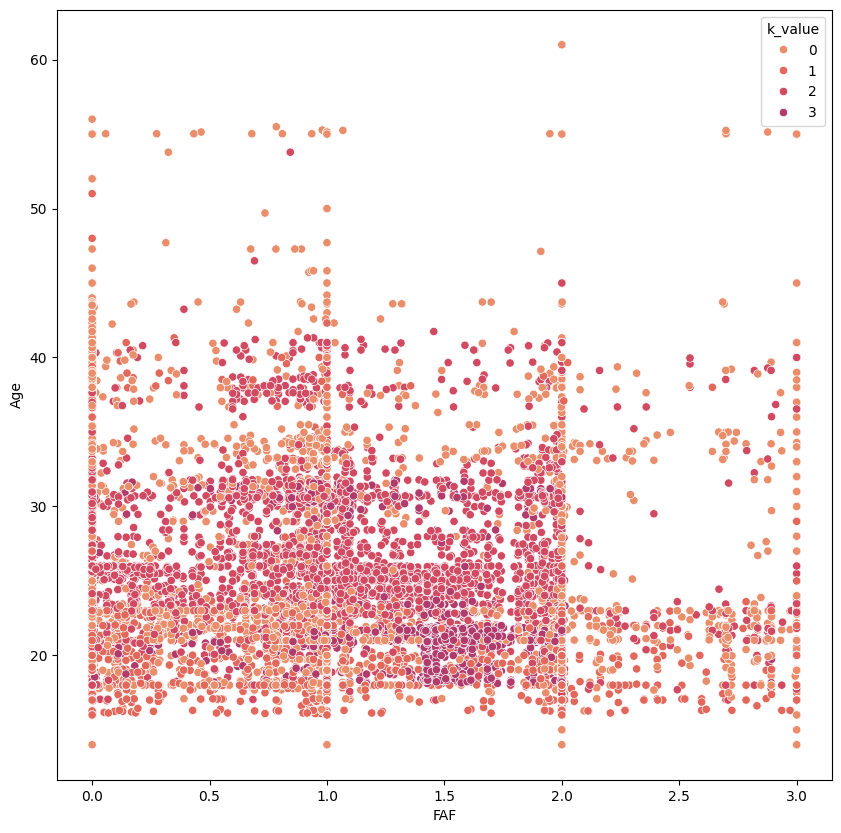

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(df4, x= 'FAF', y = 'Age', hue = 'k_value',  palette = sns.color_palette("flare"))


<ipython-input-153-92dcd95aa2ce>:2: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(df4, x= 'Height', y = 'Weight', hue = 'k_value',  palette = sns.color_palette("flare"))


<Axes: xlabel='Height', ylabel='Weight'>

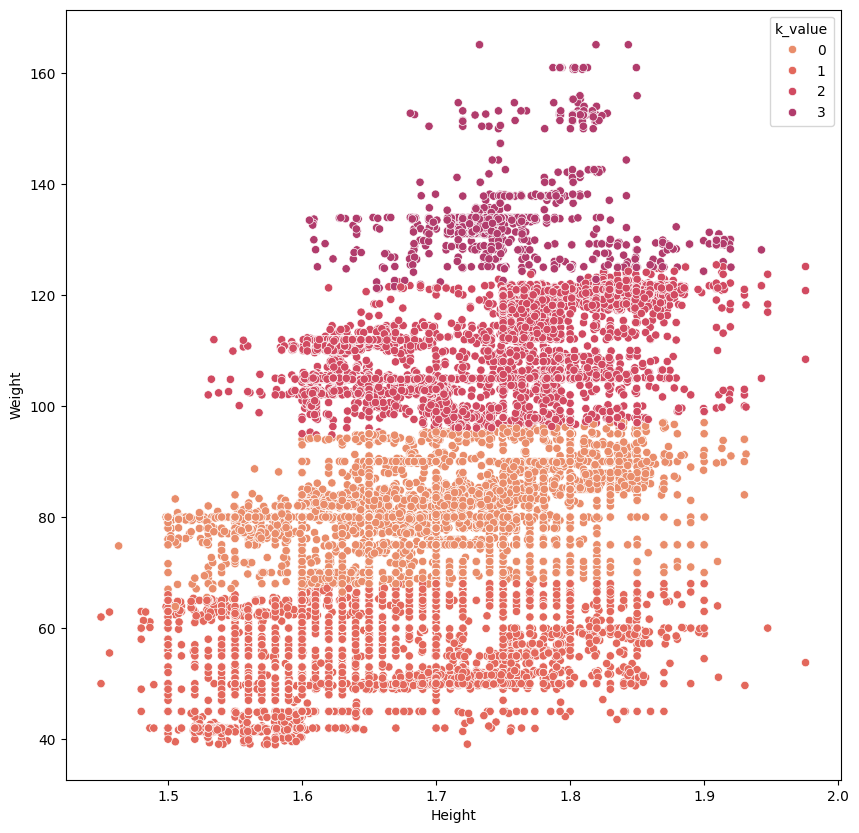

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(df4, x= 'Height', y = 'Weight', hue = 'k_value',  palette = sns.color_palette("flare"))

-- we can clearly see that people are divided on the basis on their weights in 4 clusters.

<ipython-input-154-98670d8ae133>:2: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(df4, x= 'BMI', y = 'FAF', hue = 'k_value',  palette = sns.color_palette("flare"))


<Axes: xlabel='BMI', ylabel='FAF'>

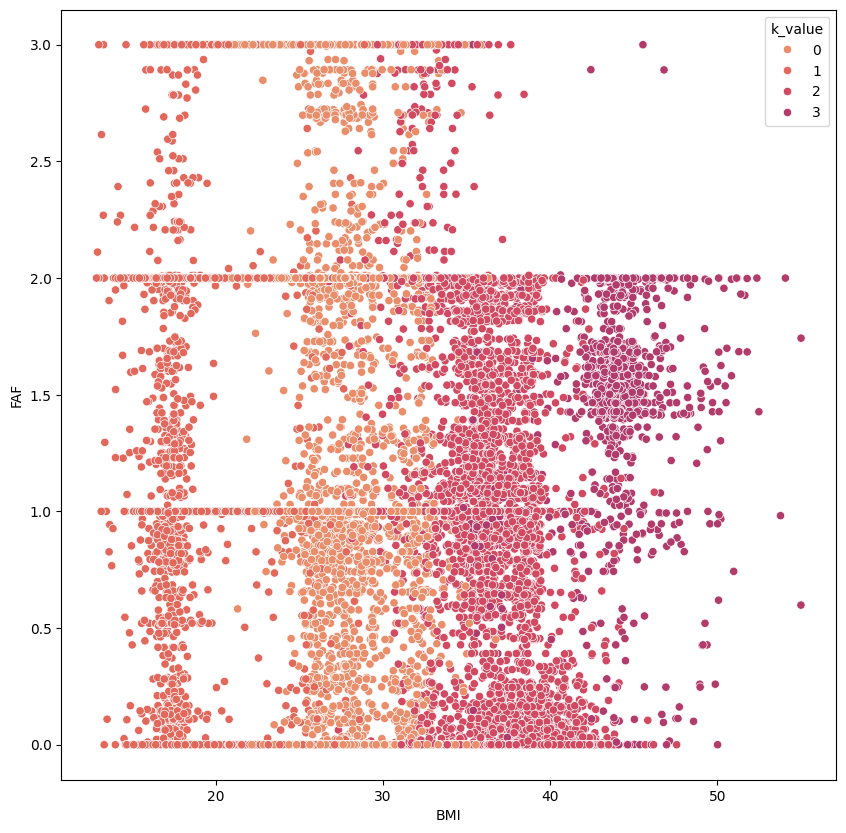

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(df4, x= 'BMI', y = 'FAF', hue = 'k_value',  palette = sns.color_palette("flare"))

### **Analysis of each cluster so that we do personlised and targeted recommendations**

In [ ]:
k1 = df4[df4['k_value']==0]
k2 = df4[df4['k_value']==1]
k3 = df4[df4['k_value']==2]
k4 = df4[df4['k_value']==3]

In [ ]:
k1.describe()

,Age,Height,Weight,FCVC,CAEC,CH2O,TUE,BMI,Gender,family_history_with_overweight,NCP,FAF,k_value
count,6831.000000,6831.000000,6831.000000,6831.000000,6831.000000,6831.000000,6831.000000,6831.000000,6831.000000,6831.000000,6831.000000,6831.000000,6831.0
mean,24.780182,1.697318,80.311271,2.211184,1.738984,2.033901,0.649115,27.984399,0.619968,0.847753,2.565862,1.086604,0.0
std,7.191070,0.076690,6.924372,0.471447,0.671705,0.591907,0.674598,2.940229,0.485430,0.359287,0.830247,0.893466,0.0
min,14.000000,1.463167,63.000000,1.000000,-1.000000,1.000000,0.000000,19.390582,0.000000,0.000000,1.000000,0.000000,0.0
25%,20.254534,1.650000,75.000000,2.000000,2.000000,1.964435,0.000000,25.951557,0.000000,1.000000,2.298612,0.170480,0.0
50%,22.188810,1.700000,80.000000,2.000000,2.000000,2.000000,0.662277,27.681661,1.000000,1.000000,3.000000,1.000000,0.0
75%,27.000000,1.750000,85.000000,2.535235,2.000000,2.174248,1.000000,30.065353,1.000000,1.000000,3.000000,1.982822,0.0
max,61.000000,1.931263,97.029249,3.000000,2.000000,3.000000,2.000000,36.741456,1.000000,1.000000,4.000000,3.000000,0.0


In [ ]:
len(k1[k1['CH2O']>2.2])/len(k1)

0.2450592885375494

In [ ]:
k1['Gender'].value_counts()

Gender
1.0    4235
0.0    2596
Name: count, dtype: int64

In [ ]:
k2.describe()

,Age,Height,Weight,FCVC,CAEC,CH2O,TUE,BMI,Gender,family_history_with_overweight,NCP,FAF,k_value
count,5428.000000,5428.000000,5428.000000,5428.000000,5428.000000,5428.000000,5428.000000,5428.000000,5428.000000,5428.000000,5428.000000,5428.000000,5428.0
mean,20.268929,1.656565,54.668241,2.414618,1.560612,1.763185,0.697990,20.024156,0.308769,0.506448,2.835609,1.115345,1.0
std,3.592374,0.091553,7.374730,0.564059,0.626051,0.567888,0.651585,3.088303,0.462028,0.500004,0.829620,0.866831,0.0
min,15.000000,1.450000,39.000000,1.000000,-1.000000,1.000000,0.000000,12.868541,0.000000,0.000000,1.000000,0.000000,1.0
25%,18.000000,1.590000,50.000000,2.000000,1.000000,1.000000,0.000000,17.531045,0.000000,0.000000,3.000000,0.129009,1.0
50%,19.434709,1.650000,54.932420,2.093507,2.000000,2.000000,1.000000,19.149510,0.000000,1.000000,3.000000,1.000000,1.0
75%,21.000000,1.719827,60.000000,3.000000,2.000000,2.000000,1.000000,22.143037,1.000000,1.000000,3.000000,2.000000,1.0
max,51.000000,1.975663,69.000000,3.000000,2.000000,3.000000,2.000000,29.653915,1.000000,1.000000,4.000000,3.000000,1.0


In [ ]:
len(k2[k2['CH2O']>2.2])/len(k2)

0.10445836403831982

In [ ]:
k2['Gender'].value_counts()

Gender
0.0    3752
1.0    1676
Name: count, dtype: int64

In [ ]:
k3.describe()

,Age,Height,Weight,FCVC,CAEC,CH2O,TUE,BMI,Gender,family_history_with_overweight,NCP,FAF,k_value
count,6935.000000,6935.000000,6935.000000,6935.000000,6935.000000,6935.000000,6935.000000,6935.000000,6935.000000,6935.000000,6935.000000,6935.000000,6935.0
mean,26.132941,1.723816,110.915801,2.594790,1.987455,2.177402,0.494171,37.493267,0.605479,0.996539,2.844562,0.670990,2.0
std,4.030650,0.083293,7.003816,0.491686,0.149949,0.581039,0.511580,3.366844,0.488783,0.058730,0.454065,0.722786,0.0
min,17.000000,1.530000,94.790579,1.000000,-1.000000,1.000000,0.000000,26.761552,0.000000,0.000000,1.000000,0.000000,2.0
25%,24.254986,1.640745,104.988082,2.024720,2.000000,2.000000,0.020044,35.279155,0.000000,1.000000,3.000000,0.000000,2.0
50%,25.999174,1.748103,111.830924,2.927187,2.000000,2.170225,0.395979,37.604884,1.000000,1.000000,3.000000,0.554646,2.0
75%,26.490926,1.786367,117.468516,3.000000,2.000000,2.644135,0.763359,40.456969,1.000000,1.000000,3.000000,1.082236,2.0
max,53.783977,1.975663,125.418548,3.000000,2.000000,3.000000,2.000000,47.559156,1.000000,1.000000,4.000000,3.000000,2.0


In [ ]:
len(k3[k3['CH2O']>2.2])/len(k3)

0.48666186012977647

<Axes: xlabel='Weight', ylabel='CH2O'>

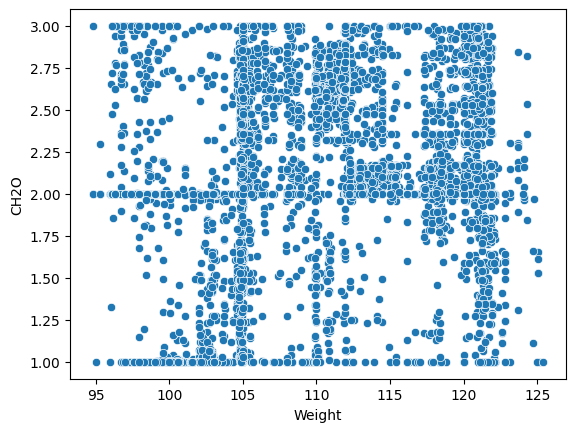

In [ ]:
sns.scatterplot(x = k3['Weight'],y = k3['CH2O'])

In [ ]:
k3['Gender'].value_counts()

Gender
1.0    4199
0.0    2736
Name: count, dtype: int64

In [ ]:
k4.describe()

,Age,Height,Weight,FCVC,CAEC,CH2O,TUE,BMI,Gender,family_history_with_overweight,NCP,FAF,k_value
count,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.0
mean,21.984053,1.760105,134.160945,2.919536,1.993606,2.277644,0.737056,43.409077,0.144501,0.999361,2.988240,1.438042,3.0
std,3.448861,0.054257,6.832974,0.245725,0.100974,0.602683,0.286609,3.091046,0.351710,0.025286,0.150385,0.413392,0.0
min,18.000000,1.605495,121.205171,1.341380,0.000000,1.000000,0.000000,33.908420,0.000000,0.000000,1.000000,0.000000,3.0
25%,20.394082,1.734092,131.282263,3.000000,2.000000,1.728139,0.673009,43.095679,0.000000,1.000000,3.000000,1.392026,3.0
50%,21.282238,1.746516,133.573787,3.000000,2.000000,2.471721,0.832458,43.832589,0.000000,1.000000,3.000000,1.488090,3.0
75%,21.768153,1.773800,133.903612,3.000000,2.000000,2.839069,0.921136,44.548372,0.000000,1.000000,3.000000,1.682490,3.0
max,33.000000,1.942725,165.057269,3.000000,2.000000,3.000000,2.000000,54.997991,1.000000,1.000000,4.000000,3.000000,3.0


In [ ]:
len(k4[k4['CH2O']>2.2])/len(k4)

0.6061381074168798

In [ ]:
k4['Gender'].value_counts()

Gender
0.0    1338
1.0     226
Name: count, dtype: int64

## **Reading recommendations data**

In [ ]:
rec = pd.read_excel('/content/recommendation (1).xlsx')

In [ ]:
rec

,Recommendation,Title,Link,Cluster
0,Boost your health by drinking more water each ...,How much water should you drink?,https://www.health.harvard.edu/staying-healthy...,1
1,"""Consider limiting snacks between meals to sup...",Gain control of emotional eating,https://www.mayoclinic.org/healthy-lifestyle/w...,2
2,"""Trimming down on snacks between meals can be ...",Always Thinking About Food? Here Are 9 Tips on...,https://www.healthline.com/nutrition/how-to-st...,3
3,"""To manage your weight effectively and improve...",Screentime to Waistline,https://zeenews.india.com/health/screen-time-t...,3
4,"""To support weight loss, prioritize vegetables...",How to Use Fruits and Vegetables to Help Manag...,https://www.cdc.gov/healthyweight/healthy_eati...,0
5,"""Utilize walking as a simple and effective way...",Walking for weight loss: 8 tips to burn fat,https://www.medicalnewstoday.com/articles/325809,2
6,"""Make walking a daily habit to prevent weight ...",How many steps you need each day to prevent we...,https://www.businessinsider.com/how-many-steps...,1
7,It's wise to consult a doctor before starting ...,Doctors Who Specialize in Obesity,https://www.hopkinsmedicine.org/health/conditi...,3
8,"To maintain your weight and prevent gain, try ...",The benefits of meal planning and prepping for...,https://www.everlywell.com/blog/weight-managem...,1
9,"""Consider trying power yoga ! It's a dynamic, ...",The Incredible Bond Between Power Yoga And Wei...,https://www.stylecraze.com/articles/how-does-p...,2


In [ ]:
 for i in rec.index:
  print(f'''{rec['Recommendation'][i]}
      Article to refer: {rec['Title'][i]}
      {rec['Link'][i]}''')
  print('-----')

Boost your health by drinking more water each day. Aim for balance - not too little, not too much. Drinking water before meals can help control appetite and manage weight. Stay hydrated for more energy, clear thinking, and better skin. Make hydration a habit for a happier, healthier you!
     Article to refer: How much water should you drink?
     https://www.health.harvard.edu/staying-healthy/how-much-water-should-you-drink
-----
"Consider limiting snacks between meals to support your weight loss goals. By reducing grazing, you can better control calorie intake and prevent overeating. Instead, focus on balanced, nutrient-rich meals to fuel your body efficiently. With mindful eating habits and proper portion control, you'll pave the way for sustainable weight loss and overall well-being."
     Article to refer: Gain control of emotional eating
     https://www.mayoclinic.org/healthy-lifestyle/weight-loss/in-depth/weight-loss/art-20047342#:~:text=Snack%20healthy.,if%20they%20satisfy%20y

In [5]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")


In [6]:
train['BMI'] = train['Weight']/(train['Height'])**2
test['BMI'] = test['Weight']/(test['Height'])**2

In [7]:
imp_col = ['Age', 'Height', 'Weight', 'FCVC','CAEC', 'CH2O','TUE','BMI','Gender','family_history_with_overweight','NCP','FAF']

In [8]:
train_df = train[imp_col]
test_df = test[imp_col]

In [9]:
train_df

,Age,Height,Weight,FCVC,CAEC,CH2O,TUE,BMI,Gender,family_history_with_overweight,NCP,FAF
0,24.443011,1.699998,81.669950,2.000000,Sometimes,2.763573,0.976473,28.259565,Male,yes,2.983297,0.000000
1,18.000000,1.560000,57.000000,2.000000,Frequently,2.000000,1.000000,23.422091,Female,yes,3.000000,1.000000
2,18.000000,1.711460,50.165754,1.880534,Sometimes,1.910378,1.673584,17.126706,Female,yes,1.411685,0.866045
3,20.952737,1.710730,131.274851,3.000000,Sometimes,1.674061,0.780199,44.855798,Female,yes,3.000000,1.467863
4,31.641081,1.914186,93.798055,2.679664,Sometimes,1.979848,0.931721,25.599151,Male,yes,1.971472,1.967973
...,...,...,...,...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,Sometimes,2.151809,0.196680,36.587084,Male,yes,3.000000,1.330519
20754,18.000000,1.710000,50.000000,3.000000,Frequently,1.000000,1.000000,17.099278,Male,no,4.000000,2.000000
20755,20.101026,1.819557,105.580491,2.407817,Sometimes,2.000000,1.198439,31.889841,Male,yes,3.000000,1.158040
20756,33.852953,1.700000,83.520113,2.671238,Sometimes,2.144838,0.973834,28.899693,Male,yes,1.971472,0.000000


In [10]:
cat_cols_enc= ['Gender','family_history_with_overweight']

In [11]:
ct_encoding = ColumnTransformer(transformers = [

              ("ord_enc", OrdinalEncoder(handle_unknown = "use_encoded_value",
                                         unknown_value = -1,categories = [['Always','Frequently','Sometimes','No']]),['CAEC']),
              ("ohe_enc", OneHotEncoder(sparse_output = False,
                                        handle_unknown = "ignore",drop = 'first'),cat_cols_enc)

], remainder = "passthrough")

In [13]:
train_data = pd.DataFrame(ct_encoding.fit_transform(train_df))
test_data = pd.DataFrame(ct_encoding.transform(test_df))

In [14]:
train_data

,0,1,2,3,4,5,6,7,8,9,10,11
0,2.0,1.0,1.0,24.443011,1.699998,81.669950,2.000000,2.763573,0.976473,28.259565,2.983297,0.000000
1,1.0,0.0,1.0,18.000000,1.560000,57.000000,2.000000,2.000000,1.000000,23.422091,3.000000,1.000000
2,2.0,0.0,1.0,18.000000,1.711460,50.165754,1.880534,1.910378,1.673584,17.126706,1.411685,0.866045
3,2.0,0.0,1.0,20.952737,1.710730,131.274851,3.000000,1.674061,0.780199,44.855798,3.000000,1.467863
4,2.0,1.0,1.0,31.641081,1.914186,93.798055,2.679664,1.979848,0.931721,25.599151,1.971472,1.967973
...,...,...,...,...,...,...,...,...,...,...,...,...
20753,2.0,1.0,1.0,25.137087,1.766626,114.187096,2.919584,2.151809,0.196680,36.587084,3.000000,1.330519
20754,1.0,1.0,0.0,18.000000,1.710000,50.000000,3.000000,1.000000,1.000000,17.099278,4.000000,2.000000
20755,2.0,1.0,1.0,20.101026,1.819557,105.580491,2.407817,2.000000,1.198439,31.889841,3.000000,1.158040
20756,2.0,1.0,1.0,33.852953,1.700000,83.520113,2.671238,2.144838,0.973834,28.899693,1.971472,0.000000


In [15]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4, random_state = 42, n_init = "auto",max_iter = 1000)

In [16]:
pipe = Pipeline(steps=[
    ("encoding", ct_encoding),
    ("model", km)
])

In [17]:
pipe.fit(train_df)

Pipeline(steps=[('encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord_enc',
                                                  OrdinalEncoder(categories=[['Always',
                                                                              'Frequently',
                                                                              'Sometimes',
                                                                              'No']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['CAEC']),
                                                 ('ohe_enc',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender',
                                                   'family_history_with_overweight'])])),
                ('model',
                 KMeans(max_iter=1000, n_clusters=4, n_init='auto',
                        random_state=42))])

In [18]:
import joblib

joblib.dump(pipe, "obesity_clustering.joblib")

['obesity_clustering.joblib']

In [19]:
new_model = joblib.load("obesity_clustering.joblib")

In [20]:
new_model.predict(test_df)

array([2, 1, 2, ..., 1, 1, 2], dtype=int32)

In [23]:
test_df['k_value'] = new_model.predict(test_df)

<ipython-input-23-bccc45e736b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['k_value'] = new_model.predict(test_df)


In [24]:
test_df['k_value'].value_counts()

k_value
0    4629
2    4586
1    3677
3     948
Name: count, dtype: int64

In [29]:
rec = pd.read_excel('/content/recommendation (1).xlsx')

In [31]:
def predict_k(data):
    k_value = km.predict(data)
    for i in range(4):
        if k_value == i:
            df = rec[rec['Cluster'] == i]
            for idx in df.index:
                print(f"{df['Recommendation'][idx]}")
                print(f"Article to refer: \033[1m{df['Title'][idx]}\033[0m")
                print(f"{df['Link'][idx]}")
                print('-----')


In [27]:
temp_df = [[2.0,1.0,1.0,26.899886,1.848294,120.644178,2.938616,2.825629,0.000000,28.259565,3.000000,0.855400]]

In [32]:
predict_k(temp_df)

"Consider limiting snacks between meals to support your weight loss goals. By reducing grazing, you can better control calorie intake and prevent overeating. Instead, focus on balanced, nutrient-rich meals to fuel your body efficiently. With mindful eating habits and proper portion control, you'll pave the way for sustainable weight loss and overall well-being."
Article to refer: Gain control of emotional eating
https://www.mayoclinic.org/healthy-lifestyle/weight-loss/in-depth/weight-loss/art-20047342#:~:text=Snack%20healthy.,if%20they%20satisfy%20your%20craving.
-----
"Utilize walking as a simple and effective way to aid in weight loss. Start with a manageable distance and gradually increase pace and duration as fitness improves. Aim for at least 30 minutes of brisk walking most days of the week to burn calories, improve cardiovascular health, and support weight loss goals. Pair walking with a balanced diet for optimal results."
Article to refer: Walking for weight loss: 8 tips to bur